
<hr>

#*Pilotaje para la prueba de tamizaje para evaluación de lesiones dermatológicas como ayuda diagnostica a través de inteligencia artificial.*


**Cuál es el objetivo?**

Crear una herramienta en línea que pueda indicar a los médicos y técnicos de laboratorio los tres diagnósticos de mayor probabilidad para una determinada lesión de piel. Esto les ayudará a identificar rápidamente a los pacientes de alta prioridad y a acelerar su flujo de trabajo, luego reducir la probabilidad de desarrolar algun tipo de cancér que ponga en peligro al paciente. La aplicación debería producir un resultado en menos de 3 segundos. Para asegurar la privacidad, las imágenes deben ser pre-procesadas y analizadas localmente y nunca ser subidas a un servidor externo.

In [ ]:
!/opt/bin/nvidia-smi
!nvcc --version

Tue Mar 28 02:05:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+

In [ ]:
from numpy.random import seed
seed(101)
import tensorflow
tensorflow.random.set_seed(101)


import pandas as pd
import numpy as np
#import keras
#from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D

**LABELS**<br>

Excerpts from the paper:<br>
> The HAM10000 Dataset: A Large Collection of Multi-Source Dermatoscopic Images of Common Pigmented Skin Lesions<br>
https://arxiv.org/abs/1803.10417



 **nv**<br>
 Los nevos melanocíticos son neoplasias benignas de los melanocitos y se presentan en una miríada de variantes, todas ellas incluidas en nuestra serie. Las variantes pueden diferir significativamente desde el punto de vista dermatoscópico.<br>
 *[6705 images]*
 
 **mel**<br>
 El melanoma es una neoplasia maligna derivada de los melanocitos que puede aparecer en diferentes variantes. Si se extirpa en una fase temprana, puede curarse mediante una simple escisión quirúrgica. Los melanomas pueden ser invasivos o no invasivos (in situ). Incluimos todas las variantes de melanoma, incluido el melanoma in situ, pero excluimos el melanoma no pigmentado, subungueal, ocular o de las mucosas.<br>*[1113 images]*
 
 
**bkl**<br>
 La "queratosis benigna" es una clase genérica que incluye la queratosis seborreica ("verruga senil"), el lentigo solar -que puede considerarse una variante plana de la queratosis seborreica- y la queratosis de tipo liquen plano (LPLK), que corresponde a una queratosis seborreica o a un lentigo solar con inflamación y regresión [22]. Los tres subgrupos pueden tener un aspecto dermatoscópico diferente, pero los hemos agrupado porque son similares desde el punto de vista biológico y a menudo se presentan bajo el mismo término genérico desde el punto de vista histopatológico. Desde el punto de vista dermatoscópico, las queratosis similares al liquen plano son especialmente difíciles porque pueden mostrar características morfológicas que imitan al melanoma [23] y a menudo se les practica una biopsia o una extirpación por motivos de diagnóstico. .<br>
*[1099 images]*

**bcc**<br>
El carcinoma basocelular es una variante común del cáncer de piel epitelial que rara vez hace metástasis, pero que crece destructivamente si no se trata. Aparece en diferentes variantes morfológicas (plano, nodular, pigmentado, quístico, etc.) [21], todas ellas incluidas en este conjunto.<br>
*[514 images]*
 
**akiec**<br>
Las queratosis actínicas (queratosis solares) y el carcinoma intraepitelial (enfermedad de Bowen) son variantes comunes no invasivas del carcinoma de células escamosas que pueden tratarse localmente sin cirugía. Algunos autores los consideran precursores de los carcinomas de células escamosas y no carci- nomas propiamente dichos. Sin embargo, hay acuerdo en que estas lesiones pueden evolucionar hacia un carcinoma de células escamosas invasivo, que normalmente no está pigmentado. Ambas neoplasias suelen mostrar escamas en la superficie y suelen carecer de pigmento. Las queratosis actínicas son más comunes en la cara y la enfermedad de Bowen es más común en otras zonas del cuerpo. Dado que ambos tipos son producidos por la luz ultravioleta, la piel circundante suele estar muy dañada por el sol, excepto en los casos de la enfermedad de Bowen, que están causados por la infección del virus del papiloma humano y no por la luz ultravioleta. Existen variantes pigmentadas para la enfermedad de Bowen [19] y para las queratosis actínicas [20]. Ambas se incluyen en este conjunto.<br>*[327 images]*


**vasc**<br>
Las lesiones vasculares de la piel en el conjunto de datos van desde los angiomas de cereza hasta los angioqueratomas [25] y los granulomas piogénicos [26]. Las hemorragias también se incluyen en esta categoría.<br>
*[142 images]*

**df**<br>
El dermatofibroma es una lesión cutánea benigna considerada como una proliferación benigna o una reacción inflamatoria a un traumatismo mínimo. Es de color marrón y a menudo muestra una zona central de fibrosis dermatoscópica [24].<br>*[115 images]*


<br>*[Total images = 10015]*

In [ ]:
from google.colab import files
files.upload()
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
!mkdir data
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Saving kaggle.json to kaggle.json
100% 5.19G/5.20G [00:31<00:00, 168MB/s]
100% 5.20G/5.20G [00:31<00:00, 179MB/s]


In [ ]:
# Unzip the whole zipfile into /content/data
!unzip -o /content/skin-cancer-mnist-ham10000.zip -d data
# Quietly unzip the image files
#!unzip -o /content/data/HAM10000_images_part_1 -d data
#!unzip -o /content/data/HAM10000_images_part_2 -d data
# Tell me how many files I unzipped///
!echo files in /content/data: `ls data | wc -l`

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: data/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: data/ham10000_images_part_

In [ ]:
os.listdir('/content/data')

['ham10000_images_part_2',
 'HAM10000_metadata.csv',
 'HAM10000_images_part_2',
 'hmnist_8_8_L.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_RGB.csv',
 'ham10000_images_part_1',
 'HAM10000_images_part_1']

In [ ]:
data = pd.read_csv('/content/data/hmnist_28_28_RGB.csv' )

In [ ]:
y = data['label']
x = data.drop(columns = ['label'])

In [ ]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [ ]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 28, 28, 3)


Analisis Exploratorio

In [ ]:
tabular_data = pd.read_csv('/content/data/HAM10000_metadata.csv')
tabular_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}

Text(0.5, 1.0, 'Frequency Distribution of Classes')

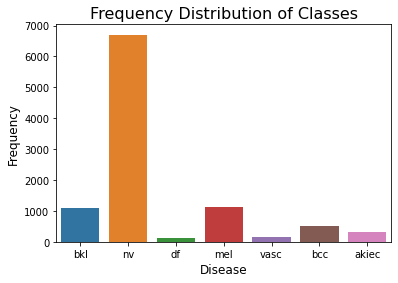

In [ ]:
"""Frequency Distribution of Classes"""

sns.countplot(x = 'dx', data = tabular_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

Text(0.5, 1.0, 'Gender of Patient')

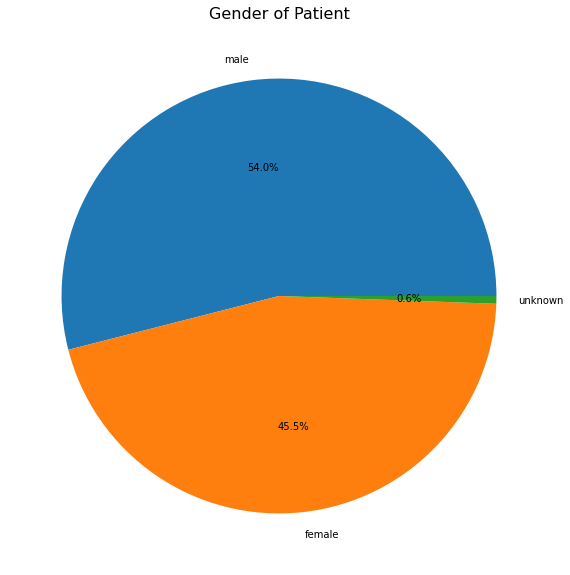

In [ ]:
"""Distribution of Disease over Gender"""

bar, ax = plt.subplots(figsize = (10,10))
plt.pie(tabular_data['sex'].value_counts(), labels = tabular_data['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

Text(0.5, 1.0, 'Histogram of Age of Patients')

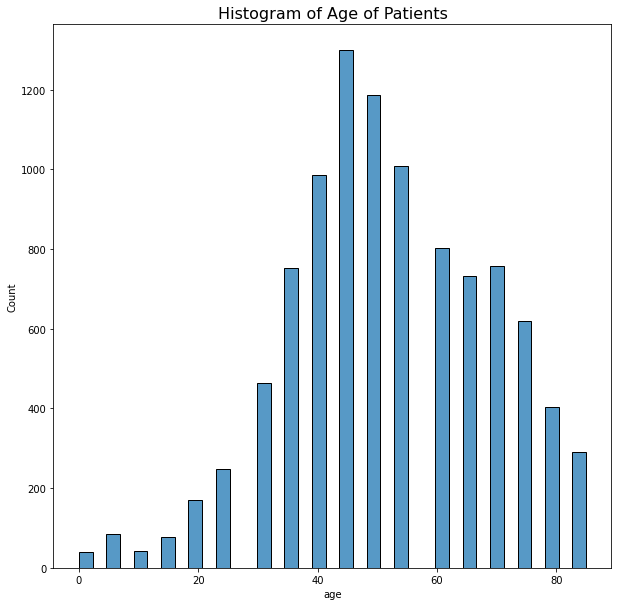

In [ ]:
"""Histogram of Age of Patients"""

bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(tabular_data['age'])
plt.title('Histogram of Age of Patients', size=16)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

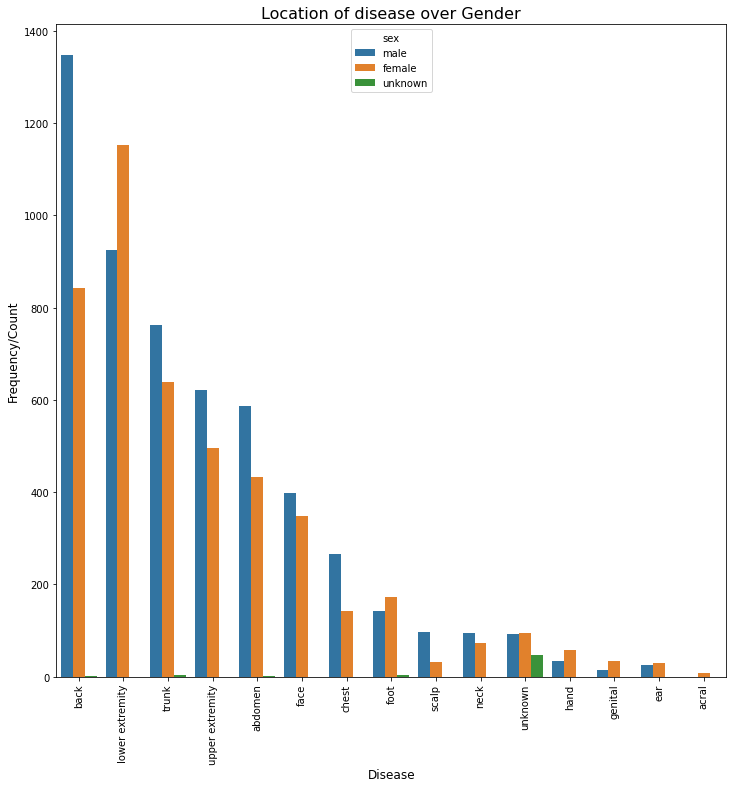

In [ ]:
"""Location of disease over Gender"""

value = tabular_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)

Balanceo 

In [ ]:
t = np.zeros([46935, 32, 32, 3],dtype=np.float32)
print(t.shape)

(46935, 32, 32, 3)


In [ ]:
import scipy.ndimage

In [ ]:
for i in range(46935):
    t[i] = scipy.ndimage.zoom(x[i],32/28)

In [ ]:
x = np.array(t).reshape(-1,32,32,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 32, 32, 3)


In [ ]:
"""Standardization and Splitting Data"""

x = (x-np.mean(x))/np.std(x)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

Entrenamiento modelo

In [ ]:
vgg=tf.keras.applications.VGG19(input_shape=(32,32,3),weights='imagenet', include_top=False)
for i in vgg.layers:
    i.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.models.Sequential([
    vgg,
    tf.keras.layers.Conv2D(128, (3, 3), padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Conv2D(64, (3, 3), padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Conv2D(32, (3, 3), padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation = 'softmax')
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 1, 1, 128)         589952    
                                                                 
 activation (Activation)     (None, 1, 1, 128)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 64)          73792     
                                                                 
 activation_1 (Activation)   (None, 1, 1, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 32)          18464     
                                                                 
 activation_2 (Activation)   (None, 1, 1, 32)          0

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 30,
                    callbacks=[callback])

Epoch 1/30
233/235 [============================>.] - ETA: 0s - loss: 0.0527 - accuracy: 0.9817
Epoch 1: saving model to best_model.h5
235/235 [==============================] - 13s 34ms/step - loss: 0.0530 - accuracy: 0.9815 - val_loss: 0.1941 - val_accuracy: 0.9535
Epoch 2/30
235/235 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.9762
Epoch 2: saving model to best_model.h5
235/235 [==============================] - 7s 30ms/step - loss: 0.0671 - accuracy: 0.9762 - val_loss: 0.1756 - val_accuracy: 0.9579
Epoch 3/30
235/235 [==============================] - ETA: 0s - loss: 0.0439 - accuracy: 0.9852
Epoch 3: saving model to best_model.h5
235/235 [==============================] - 7s 30ms/step - loss: 0.0439 - accuracy: 0.9852 - val_loss: 0.1694 - val_accuracy: 0.9690
Epoch 4/30
233/235 [============================>.] - ETA: 0s - loss: 0.0424 - accuracy: 0.9846
Epoch 4: saving model to best_model.h5
235/235 [==============================] - 7s 30ms/step - loss:

Gráfica de accuracy y loss

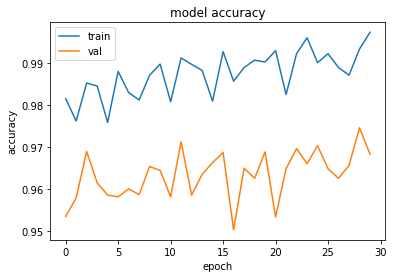

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Loss (training vs validation dataset)¶


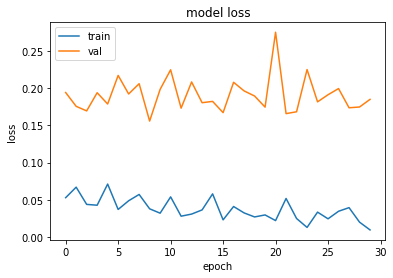

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('best_model.h5')

Test del modelo

In [58]:
loss, acc = model.evaluate(X_train, Y_train, verbose=2)

1174/1174 - 14s - loss: 0.0542 - accuracy: 0.9881 - 14s/epoch - 12ms/step


In [ ]:
loss, acc = model.evaluate(X_test, Y_test, verbose=2)

294/294 - 3s - loss: 0.1970 - accuracy: 0.9661 - 3s/epoch - 11ms/step


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics

In [ ]:
import sklearn.metrics as metrics

y_pred_ohe = model.predict(X_test) 
y_pred_labels = np.argmax(y_pred_ohe, axis=1) 

confusion_matrix = metrics.confusion_matrix(y_true=Y_test, y_pred=y_pred_labels)

294/294 [==============================] - 3s 9ms/step


In [ ]:
class_labels = ['akiec','bcc','bkl','df','nv','vasc','mel']
report = sklearn.metrics.classification_report(Y_test, y_pred_labels, target_names = class_labels)
print(report) 

              precision    recall  f1-score   support

       akiec       0.99      1.00      0.99      1359
         bcc       0.99      0.99      0.99      1318
         bkl       0.93      0.98      0.95      1262
          df       1.00      1.00      1.00      1351
          nv       0.96      0.83      0.89      1374
        vasc       0.99      1.00      1.00      1358
         mel       0.90      0.97      0.94      1365

    accuracy                           0.97      9387
   macro avg       0.97      0.97      0.97      9387
weighted avg       0.97      0.97      0.97      9387



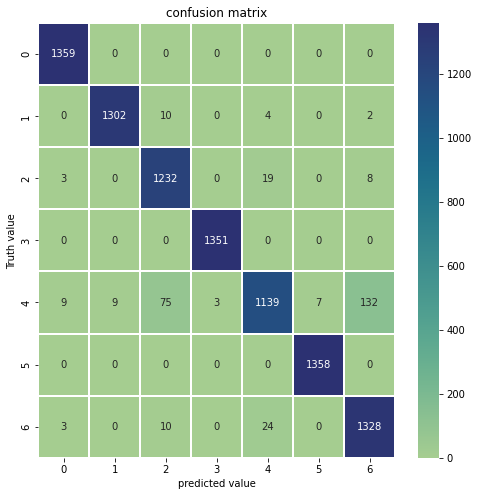

[[1359    0    0    0    0    0    0]
 [   0 1302   10    0    4    0    2]
 [   3    0 1232    0   19    0    8]
 [   0    0    0 1351    0    0    0]
 [   9    9   75    3 1139    7  132]
 [   0    0    0    0    0 1358    0]
 [   3    0   10    0   24    0 1328]]


In [ ]:
cm = sklearn.metrics.confusion_matrix(Y_test, y_pred_labels)
plt.figure(figsize=(8,8))
sns.heatmap(cm, fmt='.0f', cmap="crest", annot=True, linewidths=0.2 )
plt.title('confusion matrix')
plt.xlabel('predicted value')
plt.ylabel('Truth value')
plt.show()
print(sklearn.metrics.confusion_matrix(Y_test, y_pred_labels))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


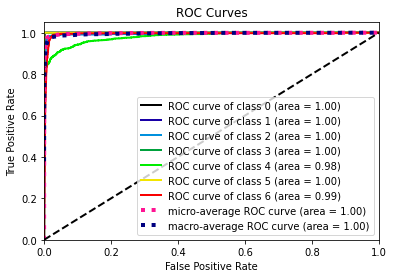

In [57]:
!pip install scikit-plot
import scikitplot as skplt

skplt.metrics.plot_roc_curve(Y_test, y_pred_ohe)
plt.show()

### Install Tensorflow.js

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 KB 10.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow-decision-forests to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 69.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.13.0
    Uninstalling tensorflow-hub-0.13.0:
      Successfully uninstalled tensorf

### Convert the model from Keras to Tensorflowjs
The conversion code below no longer works in kaggle kernels. I've left it in for reference. 

In order to convert this model the workaround is as follows:<br>
1mommmm. Recreate the model using native Keras.<br>
2. Use the command line conversion process to convert the model from Keras to Tensorflowjs.<br>
Here's how to do that: https://www.youtube.com/watch?v=Kc2_x6pBYGE

The above steps can be done in a kaggle kernel quite easily. Tensorflowjs is still fairly new so these type of bugs are not unusual.

In [62]:
# create a directory to store the model files
#os.mkdir('tfjs_dir')

#model.save('model.h5')

# convert to Tensorflow.js


# Error
# AttributeError: module 'tensorflow.python.data.ops.dataset_ops' 
    # has no attribute 'UnaryDataset'

!mkdir model
!tensorflowjs_converter --input_format keras model model/
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, 'tfjs_dir')


mkdir: cannot create directory ‘model’: File exists
2023-03-28 02:52:31.157377: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-28 02:52:31.157484: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-28 02:52:31.157503: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Trace

In [63]:
!zip -r model.zip model 

from google.colab import files
files.download('model.zip')

updating: model/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
# check the the directory containing the model is available
!ls

best_model.h5  kaggle.json  model.zip	 skin-cancer-mnist-ham10000.zip
data	       model	    sample_data  tfjs_dir


In [55]:
# view the files that make up the tensorflow.js model
#os.listdir('tfjs_dir')

In [56]:
# Delete the image data directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

#shutil.rmtree('base_dir')

### Resources

These are some resources that I used:

1. Excellent tutorial series by deeplizard on how to use Mobilenet with Tensorflow.js<br>
https://www.youtube.com/watch?v=HEQDRWMK6yY

2. Tutorial by Minsuk Heo on Accuracy, Precision and F1 Score<br>
https://www.youtube.com/watch?v=HBi-P5j0Kec

3. Tutorial by Data School on how to evaluate a classifier<br>
https://www.youtube.com/watch?v=85dtiMz9tSo

3. Tensorflow.js gallery of projects<br>
https://github.com/tensorflow/tfjs/blob/master/GALLERY.md

